# Before getting started

Make sure pixi is up to date by running the following command in your terminal:

```bash
pixi self-update
```

# Start JupyterLab

To get the Jupyter kernel to work, 

1. Run the following commands in the terminal in the ispy-readii directory:
    ```bash
    pixi shell --manifest-path=./pixi.toml

    pixi install

    pixi run make_kernel
    ```
2. In the `Select Kernel` menu at the top right of the notebook, select `Jupyter Kernel` as the source. 

3. Refresh the options and one called `ispy-readii` should appear. Select this option.

# Imports

In [16]:
# General Imports
import os
import pandas as pd
import subprocess
import numpy as np
import matplotlib.pyplot as plt

# Path handling
from pathlib import Path

# Image Processing Libraries
import SimpleITK as sitk
from imgtools.io import read_dicom_series
from imgtools.autopipeline import AutoPipeline
from readii.loaders import loadSegmentation
from readii.image_processing import flattenImage
from readii.feature_extraction import singleRadiomicFeatureExtraction

## Set  Dataset Name 

In [17]:
DATASET_NAME = "ISPY2"

# ~~Run Med-Imagetools crawl~~

~~This creates a file used by READII to associate the images with the corresponding segmentation files.~~

~~This doesn't work for ISPY2, will be using code from `workflow/scripts/python/solid-BET-FSL.py` lines 36-52 here~~



In [18]:
# mit_input_dir = f"../../rawdata/{DATASET_NAME}"
# mit_output_dir = f"../../procdata/{DATASET_NAME}/mit_output"

# modalities = "MR,SEG"
# # LEAVE THIS ONE
# dry_run = False

# # Set up and run the pipeline
# pipeline = AutoPipeline(input_directory=mit_input_dir,
#                         output_directory=mit_output_dir,
#                         modalities=modalities,
#                         dry_run=dry_run,
#                         show_progress=False) 

# pipeline.run()


# Convert MRI to NIfTI  
~~Refer to lines 36–52 in `workflow/scripts/python/solid-BET-FSL.py`~~

The only two MRI scans that match the size of our segmentation are:

In [ ]:
# Define raw DICOM directory and output NIfTI path
MR_image_dir_path = Path(f"../../rawdata/{DATASET_NAME}/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/51800.000000-ISPY2 VOLSER uni-lateral cropped original DCE-30523/")
nifti_output_path = Path(f"../../procdata/{DATASET_NAME}/ISPY2-100899/converted_niftis/MR/ISPY2-100899_raw.nii.gz")

# Read all DICOM files as a 3D volume
reader = sitk.ImageSeriesReader()
dicom_series = reader.GetGDCMSeriesFileNames(str(MR_image_dir_path))
reader.SetFileNames(dicom_series)
mri_image = reader.Execute()

# Save the raw MRI as NIfTI
sitk.WriteImage(mri_image, str(nifti_output_path))
print(f" DICOM converted to NIfTI: {nifti_output_path}")

 DICOM converted to NIfTI: ..\..\procdata\ISPY2\ISPY2-100899\converted_niftis\ISPY2-100899\MR\ISPY2-100899_raw.nii.gz


# Run Bias Correction

The `install_fsl.sh` lines 81-94 here. script installs `fsl-base` and `fslpy`, but there is an error with `fast`, which is used for bias correction. 
Therefore, an alternative approach is used instead of FSL. Here, `ANTs N4BiasFieldCorrection` is applied. 

Reference to Bias Correction:[N4 Bias Field Correction](https://simpleitk.org/doxygen/v2_3/html/classitk_1_1simple_1_1N4BiasFieldCorrectionImageFilter.html)  

In [ ]:
# Input NIfTI file (already converted from DICOM), Set Output path for bias-corrected image
bias_corr_path = Path(f"../../procdata/{DATASET_NAME}/ISPY2-100899/bias_corrected_MR/MR/processed_image.nii.gz")

# Load the NIfTI image
print("Loading NIfTI file...")
input_image = sitk.ReadImage(str(nifti_output_path))

# Convert image to float32 (avoids intensity scaling issues)
input_image = sitk.Cast(input_image, sitk.sitkFloat32)

# Apply N4 Bias Field Correction
print("Applying N4 Bias Field Correction...")
corrector = sitk.N4BiasFieldCorrectionImageFilter()
output_image = corrector.Execute(input_image)
# Save the bias-corrected image as NIfTI
sitk.WriteImage(output_image, str(bias_corr_path))
print(f"Bias correction applied. Output saved at: {bias_corr_path}")

In [ ]:
# Load NIfTI images
input_image = sitk.ReadImage(nifti_output_path)
MR_corrected_image = sitk.ReadImage(bias_corr_path)

# Convert to NumPy arrays
original_array = sitk.GetArrayFromImage(input_image)
corrected_array = sitk.GetArrayFromImage(MR_corrected_image)

# Show only the first 20 slices (max is 640)
num_slices = min(20, original_array.shape[0])

# Plot slices
for slice_idx in range(num_slices):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].imshow(original_array[slice_idx], cmap="gray")
    ax[0].set_title(f"Original - Slice {slice_idx}")

    ax[1].imshow(corrected_array[slice_idx], cmap="gray")
    ax[1].set_title(f"Corrected - Slice {slice_idx}")

    plt.show()

# Load in image and segmentation

In [ ]:
# Path to the SEG file
segmentation_file_path = Path(f"../../rawdata/{DATASET_NAME}/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/51900.000000-ISPY2 VOLSER uni-lateral cropped Analysis Mask-78091/1-1.dcm")

# Load the segmentation file (for SEG format)
# This returns a dictionary of segmentation images, with ROI names as keys and image objects as values
seg_image_dict = loadSegmentation(segmentation_file_path, modality='SEG')

# Get the segmentation image for the specific ROI of interest
# Flatten the image if it has extra dimensions, making it 3D
seg_image = flattenImage(seg_image_dict["VOLSER Analysis Mask"])


print("SEG image size:", seg_image.GetSize())
print("MR bias correction size:", MR_corrected_image.GetSize())


SEG image size: (256, 256, 80)
MR bias correction size: (256, 256, 640)



# MRI Cropping and Segmentation Binarization  

- **Reference**: [ISPY2 TCIA Collection](https://www.cancerimagingarchive.net/collection/ispy2/)  
- **Documentation**: See *Analysis-mask-files-description.v20211020.doc* for details on FTV (Functional Tumor Volume) mask generation.  
- **Relevant Studies**: *Breast-MRI-NACT-Pilot (I-SPY 1)* and *ACRIN_6657 / ACRIN_6698 (I-SPY 2)*  

The FTV masking pipeline on DCE-MRI scans includes: (1) Manual VOI definition, (2) Background masking, (3) Percent Enhancement (PE) thresholding, (4) Connectivity filtering, and (5) Manual exclusion of non-tumor regions.

> **Note**: These are **inverse masks**, where 0 indicates **FTV-included tumor voxels**.

Our current segmentation includes multiple values: `[0, 1, 2, 17, 32, 33, 34, 49]`. However, **PyRadiomics requires binary masks** with only 0 (background) and 1 (tumor). To prepare the masks:  
- Voxels with value 0 (tumor) → set to 1  
- Voxels with values ≥ 1 (non-tumor) → set to 0 

This ensures compatibility with PyRadiomics while preserving the FTV-included region.


In [ ]:
# SEG binarization
# with the loaded nifti SEG file:
# convert it to a numpy array
# make a copy of the array
# in the copy, set values in original >= 1 to 0, values in original == 0 to 1
# now the tumor will be 1, and everything else will be 0
# print a slice of the copy to confirm

Original SEG values: [ 0  1  2 17 32 33 34 49]
Binary mask values: [0 1]


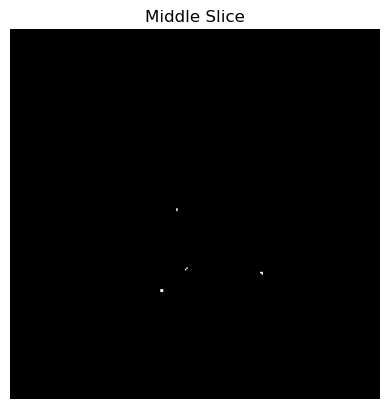

Valid slices (tumor + background): 33 / 80 (41.25%)
Slice indices: [27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


In [123]:
# 1. SEG binarization

# Convert SEG image to NumPy array
seg_array = sitk.GetArrayFromImage(seg_image)

# Binarize: Set tumor (value 0) to 1, and non-tumor (value ≥1) to 0
binary_seg = np.where(seg_array == 0, 1, 0)
binary_seg_image = sitk.GetImageFromArray(binary_seg)

# Check unique values
print("Original SEG values:", np.unique(seg_array))
print("Binary mask values:", np.unique(binary_seg))

# Show middle slice
mid_slice = binary_seg.shape[0] // 2
plt.imshow(binary_seg[mid_slice], cmap='gray')
plt.title("Middle Slice")
plt.axis('off')
plt.show()

# Slices with both tumor and background
valid_slices = [i for i in range(binary_seg.shape[0]) if np.array_equal(np.unique(binary_seg[i]), [0, 1])]
print(f"Valid slices (tumor + background): {len(valid_slices)} / {binary_seg.shape[0]} ({100 * len(valid_slices) / binary_seg.shape[0]:.2f}%)")
print(f"Slice indices: {valid_slices}")

In [ ]:
# 2. MRI Cropping
# Get number of slices (z-axis) from the SEG
# Crop the MRI to that number of slices
# Need to figure out which end of the slices of the image to start from for cropping

# Confirm that the images have the same size 
# Try saving them as niftis and view them with NiiVue extension in VS Code

In [ ]:
# 2. MRI Cropping

# Get number of slices (z-axis) from SEG
num_slices = seg_array.shape[0]

# Crop MRI image along z-axis to match SEG
# (Assumes MRI and SEG are aligned spatially and have same orientation)
mri_array = sitk.GetArrayFromImage(mri_image)
cropped_mri = mri_array[:num_slices]  # Adjust as needed (start vs. end alignment)

# Optional: check shape match
print("SEG shape:", seg_array.shape)
print("Cropped MRI shape:", cropped_mri.shape)

# Save cropped image as nifti 
# procdata/ISPY2/ISPY2-100899/Cropped_binarized_MR/cropped_mri.nii.gz
# opr nifti 


In [ ]:
# Convert SEG and MRI to arrays
seg_array = sitk.GetArrayFromImage(seg_image)
mri_array = sitk.GetArrayFromImage(mri_image)

# Get number of slices in SEG
num_seg_slices = seg_array.shape[0]
num_mri_slices = mri_array.shape[0]

print(f"SEG slices: {num_seg_slices}")
print(f"MRI slices: {num_mri_slices}")

# Test start vs. end slice match with SEG
diff_start = np.abs(mri_array[:num_seg_slices] - seg_array).sum()
diff_end = np.abs(mri_array[-num_seg_slices:] - seg_array).sum()

# Crop accordingly
if diff_start < diff_end:
    cropped_mri_array = mri_array[:num_seg_slices]
    print("Cropping MRI from the top (start).")
else:
    cropped_mri_array = mri_array[-num_seg_slices:]
    print("Cropping MRI from the bottom (end).")

# Convert cropped array to image
cropped_mri_image = sitk.GetImageFromArray(cropped_mri_array)

# Copy spacing/origin/direction from SEG (not MRI) because it matches the new shape
cropped_mri_image.CopyInformation(seg_image)

# Save
output_path = "../../procdata/ISPY2/ISPY2-100899/Cropped_binarized_MR"
os.makedirs(output_path, exist_ok=True)
sitk.WriteImage(cropped_mri_image, os.path.join(output_path, "cropped_mri.nii.gz"))
print("Cropped MRI saved successfully.")


SEG slices: 80


MRI slices: 640
Cropping MRI from the bottom (end).
Cropped MRI saved successfully.


## Extract Radiomic Features

In [124]:
# Pick which config settings to use for PyRadiomics feature extraction
pyradiomics_param_file_path = "../config/default_pyradiomics.yaml"

# Run PyRadiomics feature extraction with REAII function
radiomic_features_dict = singleRadiomicFeatureExtraction(cropped_mri_image , binary_seg_image, pyradiomics_param_file_path, randomSeed=10)

# Convert to dataframe
rad_features_df = pd.DataFrame.from_dict(radiomic_features_dict, orient="index").transpose()


# Save out the results of the feature extraction

In [126]:
save_radiomics_path = Path("../../results/ISPY2/readii_radiomic_features.csv")
save_radiomics_path.parent.mkdir(parents=True, exist_ok=True)

rad_features_df.to_csv(save_radiomics_path, index=False)